In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import pandas as pd
import os
import time
from datetime import timedelta
import rasterio.warp as rasteriowarp

In [2]:
SATELLITE_DATA_PATH = os.path.expanduser('~/data/EUMETSAT/reprojected_subsetted/')
PV_DATA_FILENAME = os.path.expanduser('~/data/pvoutput.org/UK_PV_timeseries_batch.nc')
PV_METADATA_FILENAME = os.path.expanduser('~/data/pvoutput.org/UK_PV_metadata.csv')

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Geospatial boundary in Transverse Mercator (meters)
SOUTH = 5513500
NORTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

In [4]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [5]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 13.1 s, sys: 2.04 s, total: 15.1 s
Wall time: 15.4 s


In [6]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2018-06-01', '2019-07-01'))]

In [7]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')

In [8]:
del pv_power
del pv_power_selected

In [9]:
# A bit of hand-crafted cleaning
# TODO: Is this still relevant?
pv_power_df[30248][:'2019-01-03'] = np.NaN

In [10]:
# Scale to the range [0, 1]
pv_power_df -= pv_power_df.min()
pv_power_df /= pv_power_df.max()

In [11]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(21, 24)) + list(range(0, 4))
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]

#ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
#ax.set_title('Bad PV systems');

In [12]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [13]:
%%time
# Interpolate
pv_power_df = pv_power_df.interpolate(limit=3)

CPU times: user 21.4 s, sys: 262 ms, total: 21.7 s
Wall time: 21.7 s


In [14]:
len(pv_power_df.columns)

914

In [15]:
#pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [16]:
# Sort the metadata in the same order as the PV power data
pv_metadata = pv_metadata.reindex(pv_power_df.columns, axis='index')

## Load satellite data

In [17]:
from glob import glob
from torch.utils.data import Dataset

In [18]:
def get_rectangle(data_array, time, centre_x, centre_y, width=128000, height=128000):
    half_width = width / 2
    half_height = height / 2

    north = centre_y + half_height
    south = centre_y - half_height
    east = centre_x + half_width
    west = centre_x - half_width

    data = data_array.loc[dict(
        x=slice(west, east), 
        y=slice(north, south))]

    MEAN = 20.444992
    STD = 8.766013
    data = data - MEAN
    data = data / STD 

    return data


class SatelliteLoader(Dataset):
    def __init__(self, file_pattern):
        self._load_sat_index(file_pattern)
        self._data_array_cache = None
        self._last_filename_requested = None
        
    def __getitem__(self, dt):
        sat_filename = self.index[dt]
        if self._data_array_cache is None or sat_filename != self._last_filename_requested:
            self._data_array_cache = xr.open_dataarray(sat_filename)
            self._last_filename_requested = sat_filename
        return self._data_array_cache
        
    def __len__(self):
        return len(self.index)
        
    def _load_sat_index(self, file_pattern):
        sat_filenames = glob(file_pattern)
        sat_filenames.sort()
        
        n_filenames = len(sat_filenames)
        sat_index = []
        for i_filename, sat_filename in enumerate(sat_filenames):
            if i_filename % 10 == 0:
                print('\r {:5d} of {:5d}'.format(i_filename, n_filenames), end='', flush=True)
            data_array = xr.open_dataarray(sat_filename, drop_variables=['x', 'y'])
            sat_index.extend([(sat_filename, t) for t in data_array.time.values])

        sat_index = pd.DataFrame(sat_index, columns=['filename', 'datetime']).set_index('datetime').squeeze()
        self.index = sat_index.tz_localize('UTC')
        
    def get_rectangles_for_all_data(self, centre_x, centre_y, width=128000, height=128000):
        sat_filenames = np.sort(np.unique(self.index.values))
        for sat_filename in sat_filenames:
            data_array = xr.open_dataarray(sat_filename)
            yield get_rectangle(data_array, time, centre_x, centre_y, width, height)
        
    def get_rectangle(self, time, centre_x, centre_y, width=128000, height=128000):
        return get_rectangle(self[time], time, centre_x, centre_y, width, height)

In [19]:
%%time
sat_loader = SatelliteLoader(os.path.join(SATELLITE_DATA_PATH, '*.nc'))
print()

  3810 of  3815
CPU times: user 12.5 s, sys: 346 ms, total: 12.8 s
Wall time: 13.4 s


In [20]:
len(sat_loader)

45745

In [21]:
# Test get rectangle
dt = pd.Timestamp('2019-02-21 10:15')
pv_system_id = pv_metadata.index[0]
x, y = pv_metadata.loc[pv_system_id][['x', 'y']]

In [22]:
%%time
sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y) #, width=512000, height=512000)

CPU times: user 41.3 ms, sys: 8.24 ms, total: 49.6 ms
Wall time: 48.6 ms


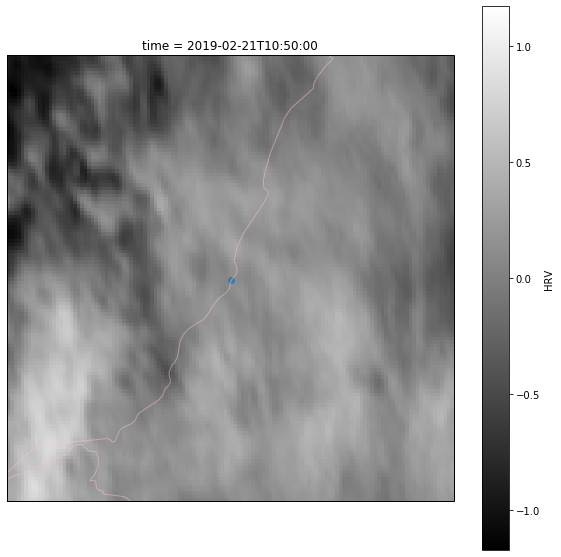

In [23]:
fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

img = sat_data.isel(time=10).plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)
path_collection = ax.scatter(x=x, y=y, alpha=0.7)

In [393]:
import pvlib
from pvlib.location import Location

In [395]:
location = Location(
    latitude=pv_metadata['latitude'][pv_system_id],
    longitude=pv_metadata['longitude'][pv_system_id],
    tz='UTC',
    name=pv_metadata['system_name'][pv_system_id])
location

Location: 
  name: AberDinoPV
  latitude: 56.896335
  longitude: -2.214077
  altitude: 0
  tz: UTC

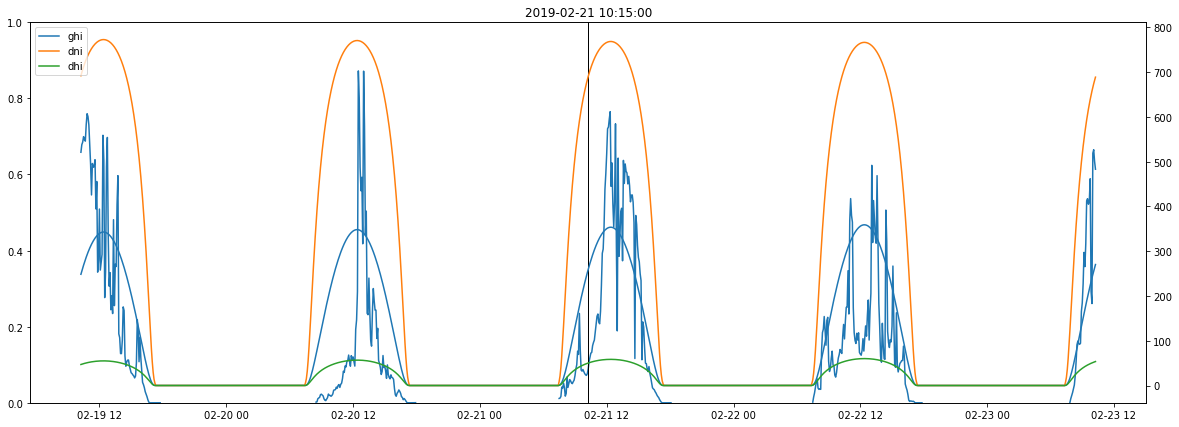

In [403]:
fig, ax = plt.subplots(figsize=(20, 7))
pv_data_to_plot = pv_power_df[pv_system_id][dt - timedelta(hours=48):dt + timedelta(hours=48)]
ax.plot(pv_data_to_plot, label='PV yield')
ax.plot((dt, dt), (0, 1), linewidth=1, color='black', label='datetime of image above')
ax.set_title(dt)
ax.set_ylim((0, 1))

ax2 = ax.twinx()
clearsky = location.get_clearsky(pv_data_to_plot.index)
lines = ax2.plot(clearsky)
for line, label in zip(lines, clearsky.columns):
    line.set_label(label);
ax2.legend(loc='upper left');

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import OrderedDict

In [26]:
%%time
# Load all satellite data rectangles into RAM
dims = OrderedDict()
dims['time'] = sat_loader.index.index.values
dims['y'] = sat_data.y
dims['x'] = sat_data.x

shape = [len(values) for values in dims.values()]
print('Creating huge numpy array!', flush=True)
data = np.zeros(shape, dtype=np.float16)
print('Setting to NaN', flush=True)
data[:, :, :] = np.NaN
print('Creating huge DataArray!', flush=True)
sat_data_master = xr.DataArray(
    data,
    coords=dims,
    dims=dims.keys(),
    name='HRV')
del data, dims, shape

for data_array in sat_loader.get_rectangles_for_all_data(centre_x=x, centre_y=y):
    print('\r', data_array.time.values[0], flush=True, end='')
    sat_data_master.loc[data_array.time.values, :, :] = data_array
    
print()

Creating huge numpy array!
Setting to NaN
Creating huge DataArray!
 2019-06-30T20:00:00.0000000002019-04-05T10:00:00.0000000002019-04-12T13:00:00.000000000CPU times: user 3min 3s, sys: 25.1 s, total: 3min 28s
Wall time: 3min 59s


In [77]:
sat_data_master = sat_data_master.dropna(dim='time', how='any')

In [78]:
# Align with PV
pv_data = pv_power_df[pv_system_id].dropna()
sat_data_index = pd.DatetimeIndex(sat_data_master.time.values, tz='UTC')
datetime_index = pv_data.index.intersection(sat_data_index)

In [82]:
len(datetime_index)

31831

In [85]:
datetime_index.tz

<UTC>

In [86]:
sat_data_master = sat_data_master.loc[datetime_index.tz_convert(None)]

In [87]:
pv_data = pv_data[datetime_index]

In [94]:
pv_data_cuda = torch.cuda.HalfTensor(pv_data.values[:, np.newaxis])
pv_data_cuda.shape

torch.Size([31831, 1])

In [140]:
sat_data_master_cuda = torch.cuda.HalfTensor(sat_data_master.values[:, np.newaxis])
sat_data_master_cuda.shape

torch.Size([31831, 1, 128, 128])

In [96]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

In [141]:
print('{:,.0f} MB CUDA memory allocated.'.format(torch.cuda.memory_allocated() / 1E6))

3,784 MB CUDA memory allocated.


In [102]:
# Split train & test by days
days = np.unique(datetime_index.date)
len(days)

204

In [104]:
# Use every 5th day for testing
testing_days = days[::5]
len(testing_days)

41

In [111]:
training_days = np.array(list(set(days) - set(testing_days)))
training_days = np.sort(training_days)
len(training_days)

163

In [126]:
def get_index_into_datetime_index(training_or_testing_days):
    return np.where(pd.Series(datetime_index.date).isin(training_or_testing_days))[0]

training_index = get_index_into_datetime_index(training_days)
testing_index = get_index_into_datetime_index(testing_days)
assert not set(training_index).intersection(testing_index)

len(training_index), len(testing_index)

(25471, 6360)

In [383]:
hours_of_day = datetime_index.hour.values.astype(np.float32)
hours_of_day -= hours_of_day.mean()
hours_of_day /= hours_of_day.std()
hours_of_day = torch.cuda.HalfTensor(hours_of_day[:, np.newaxis])

In [410]:
clearsky = location.get_clearsky(datetime_index)
clearsky -= clearsky.mean()
clearsky /= clearsky.std()
clearsky = torch.cuda.HalfTensor(clearsky.values)

In [419]:
class Net(nn.Module):
    def __init__(self, dropout_proportion=0.1):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5)
        HOURS_OF_DAY_CHANNELS = 1
        CLEARSKY_CHANNELS = 3
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120 + HOURS_OF_DAY_CHANNELS + CLEARSKY_CHANNELS, 84)
        self.fc3 = nn.Linear(84, 1)
        self.dropout_layer = nn.Dropout(p=dropout_proportion)

    def forward(self, x, hour_of_day, clearsky):
        #x = self.dropout_layer(x)
        x = self.pool(F.relu(self.conv1(x)))
        # x is now <batch_size>, 6, 62, 62.  
        # 62 is 124 / 2.  124 is the 128-dim input - 4
        x = self.dropout_layer(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x is now <batch_size>, 16, 29, 29
        x = x.view(-1, 16 * 29 * 29)
        # x is now <batch_size>, 16 x 29 x 29
        x = self.dropout_layer(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_layer(x)
        x = torch.cat((x, hour_of_day, clearsky), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().cuda().half()

In [420]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss_func = nn.MSELoss()
mae_loss_func = nn.L1Loss()

In [421]:
train_losses = []
train_mae_losses = []
test_losses = []
test_mae_losses = []

In [422]:
%%time
STATS_PERIOD = 250
TRAINING_BATCH_SIZE = 128

TESTING_BATCH_SIZE = 256
TESTING_BATCH_INDEX = testing_index[:TESTING_BATCH_SIZE]
TESTING_INPUTS = sat_data_master_cuda[TESTING_BATCH_INDEX]
TESTING_TARGET = pv_data_cuda[TESTING_BATCH_INDEX]
TESTING_HOURS_OF_DAY = hours_of_day[TESTING_BATCH_INDEX]
TESTING_CLEARSKY = clearsky[TESTING_BATCH_INDEX]

running_train_loss = 0.0
running_train_mae = 0.0
t0 = time.time()
training_index_len_minus_1 = len(training_index)-1

for i_batch in range(20000):
    print('\rBatch: {:4d}'.format(i_batch + 1), end='', flush=True)
    
    # Create batch
    batch_index = np.random.randint(low=0, high=training_index_len_minus_1, size=TRAINING_BATCH_SIZE)
    batch_index = training_index[batch_index]
    inputs = sat_data_master_cuda[batch_index]
    hours_of_day_for_batch = hours_of_day[batch_index]
    clearsky_for_batch = clearsky[batch_index]
    target = pv_data_cuda[batch_index]
    
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    net.train()
    outputs = net(inputs, hours_of_day_for_batch, clearsky_for_batch)
    train_loss = loss_func(outputs, target)
    train_loss.backward()
    optimizer.step()
    running_train_loss += train_loss.item()
    
    # MAE
    train_mae = mae_loss_func(outputs, target)
    running_train_mae += train_mae.item()

    # print statistics
    if i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches
        t1 = time.time()
        
        # Train loss
        mean_train_loss = running_train_loss / STATS_PERIOD
        train_losses.append(mean_train_loss)
        mean_train_mae = running_train_mae / STATS_PERIOD
        train_mae_losses.append(mean_train_mae)
        
        # Test loss
        net.eval()
        test_outputs = net(TESTING_INPUTS, TESTING_HOURS_OF_DAY, TESTING_CLEARSKY)
        test_loss = loss_func(test_outputs, TESTING_TARGET).item()
        test_losses.append(test_loss)
        test_mae = mae_loss_func(test_outputs, TESTING_TARGET).item()
        test_mae_losses.append(test_mae)
        
        print(
            '\n        time =   {:.2f} milli seconds per batch.\n'
            '   train loss = {:8.5f}\n'
            '    train MAE = {:8.5f}\n'
            '    test loss = {:8.5f}\n'
            '     test MAE = {:8.5f}'.format(
                ((t1 - t0) / STATS_PERIOD) * 1000,
                mean_train_loss, 
                mean_train_mae,
                test_loss,
                test_mae
            ))
        running_train_loss = 0.0
        running_train_mae = 0.0
        t0 = time.time()

print('Finished Training')

Batch:  250
        time =   49.54 milli seconds per batch.
   train loss =  0.04147
    train MAE =  0.15245
    test loss =  0.01700
     test MAE =  0.11810
Batch:  500
        time =   48.23 milli seconds per batch.
   train loss =  0.02576
    train MAE =  0.11948
    test loss =  0.01374
     test MAE =  0.10431
Batch:  750
        time =   48.67 milli seconds per batch.
   train loss =  0.02312
    train MAE =  0.11082
    test loss =  0.01245
     test MAE =  0.09656
Batch: 1000
        time =   49.50 milli seconds per batch.
   train loss =  0.02238
    train MAE =  0.10810
    test loss =  0.01183
     test MAE =  0.09277
Batch: 1250
        time =   49.46 milli seconds per batch.
   train loss =  0.02044
    train MAE =  0.10168
    test loss =  0.01089
     test MAE =  0.08728
Batch: 1500
        time =   49.10 milli seconds per batch.
   train loss =  0.01984
    train MAE =  0.10007
    test loss =  0.01028
     test MAE =  0.08435
Batch: 1750
        time =   49.34 milli

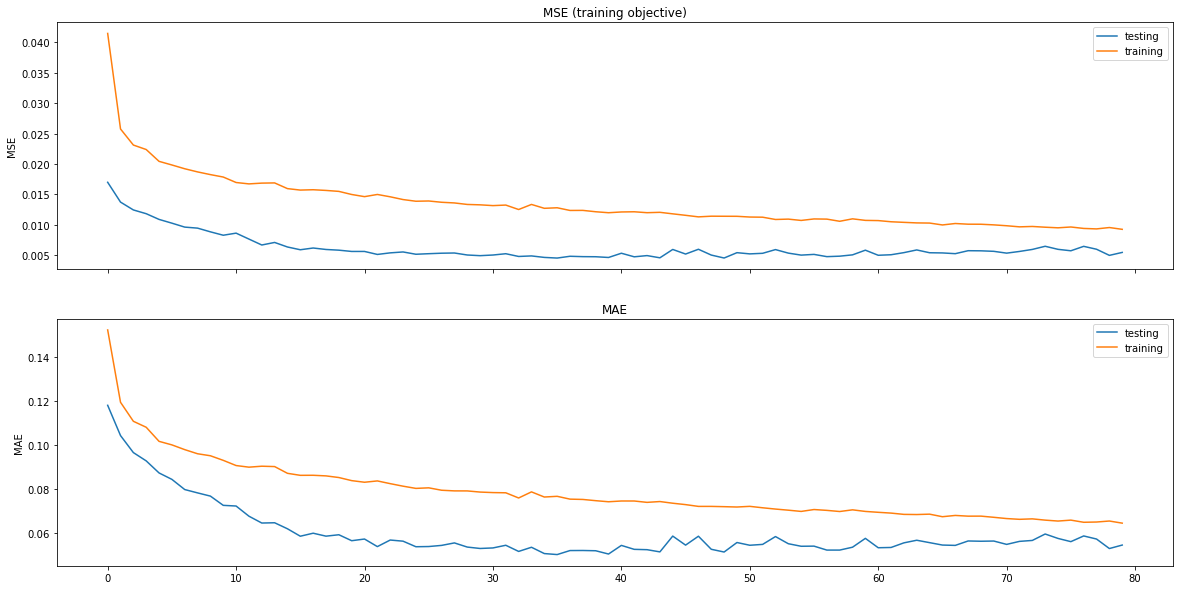

In [423]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))

ax1.plot(test_losses, label='testing')
ax1.plot(train_losses, label='training')
ax1.set_title('MSE (training objective)')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.plot(test_mae_losses, label='testing')
ax2.plot(train_mae_losses, label='training')
ax2.set_title('MAE')
ax2.set_ylabel('MAE')
ax2.legend();

In [437]:
# Get MAPE across entire testing dataset :)
net.eval()
start_i = 0
mae_on_all_testset = []
while start_i < len(testing_index) - 1:
    end_i = start_i + TESTING_BATCH_SIZE
    test_index_batch = testing_index[start_i:end_i]
    start_i = end_i
    
    inputs = sat_data_master_cuda[test_index_batch]
    testing_hour_of_day = hours_of_day[test_index_batch]
    testing_clearsky = clearsky[test_index_batch]
    target = pv_data_cuda[test_index_batch]
    output = net(inputs, testing_hour_of_day, testing_clearsky)
    mae = mae_loss_func(output, target).item()
    mae_on_all_testset.append(mae)
    
np.mean(mae_on_all_testset)

0.0804742431640625

In [471]:
%%time
# Plot some results!

#batch_index = np.random.randint(low=0, high=len(testing_index)-1, size=BATCH_SIZE)

START = 500
batch_index = range(START, START+TESTING_BATCH_SIZE + 512)
batch_index = testing_index[batch_index]

inputs = sat_data_master_cuda[batch_index]
testing_hour_of_day = hours_of_day[batch_index]
testing_clearsky = clearsky[batch_index]
target = pv_data_cuda[batch_index]

CPU times: user 611 µs, sys: 8 ms, total: 8.61 ms
Wall time: 7.41 ms


In [472]:
net.eval()
output = net(inputs, testing_hour_of_day, testing_clearsky)

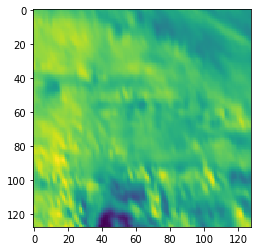

In [473]:
i = 30
plt.imshow(
    inputs[i, 0].to(device=torch.device('cpu'), dtype=torch.float32), 
    origin='upper')

In [474]:
output[i, 0].detach().cpu()

tensor(0.1092, dtype=torch.float16)

In [475]:
target[i, 0].detach().cpu()

tensor(0.1182, dtype=torch.float16)

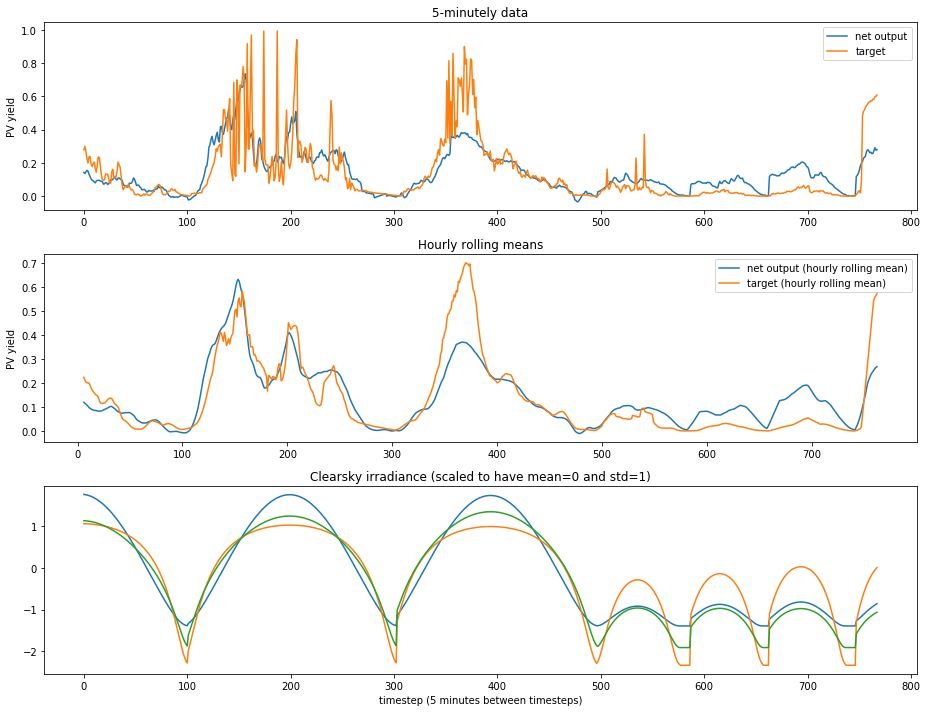

In [483]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(13,10))
#dt_index = datetime_index[batch_index]

ax1.set_title('5-minutely data')
ax1.plot(output[:, 0].detach().cpu(), label='net output')
ax1.plot(target[:, 0].detach().cpu(), label='target')

ax2.set_title('Hourly rolling means')
ax2.plot(pd.Series(output[:, 0].detach().cpu()).rolling(12, center=True).mean().values, label='net output (hourly rolling mean)')
ax2.plot(pd.Series(target[:, 0].detach().cpu()).rolling(12, center=True).mean().values, label='target (hourly rolling mean)')

ax3.plot(testing_clearsky.detach().cpu())
ax3.set_title('Clearsky irradiance (scaled to have mean=0 and std=1)')

ax1.legend()
ax2.legend()
ax1.set_ylabel('PV yield')
ax2.set_ylabel('PV yield')
ax3.set_xlabel('timestep (5 minutes between timesteps)')
fig.tight_layout();

In [480]:
np.unique(datetime_index[batch_index].date)

array([datetime.date(2018, 6, 16), datetime.date(2018, 6, 21),
       datetime.date(2018, 6, 26), datetime.date(2019, 1, 1),
       datetime.date(2019, 1, 6), datetime.date(2019, 1, 11),
       datetime.date(2019, 1, 16)], dtype=object)